In [1]:
import os
import numpy as np
import keras
from keras.applications import ResNet50V2
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.layers import Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import csv
import pandas as pd

Using TensorFlow backend.
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu

In [2]:
base_dir = r'D:\dataset\dental\data'

data = np.load(base_dir + '\\data_KNU_Diorco_so_imgs.npy')
label_csv= open(base_dir + '\\data_KNU_Diorco_so_img_labels.csv', 'r')
label = csv.reader(label_csv)

In [ ]:
right_label = []
left_label = []

for line in label:
    right_label.append(line[3])
    left_label.append(line[4])

right_label = right_label[1:]
left_label = left_label[1:]

right_label = list(map(int, right_label))
left_label = list(map(int, left_label))

right_label = np.array(right_label)
left_label = np.array(left_label)

np.save(base_dir + '\\right_label.npy', right_label)
np.save(base_dir + '\\left_label.npy', left_label)

In [3]:
right_label = np.load(base_dir + '\\right_label.npy')
left_label = np.load(base_dir + '\\left_label.npy')

In [4]:
right = data[:,:,:, 0:3]
left = data[:,:,:, 3:7]

patient_data = []
patient_data.extend(left)
patient_data.extend(right)
patient_data = np.array(patient_data)

patient_labels = []
patient_labels.extend(left_label)
patient_labels.extend(right_label)
patient_labels = np.array(patient_labels)

In [5]:
train_data, test_data, train_label, test_label= train_test_split(patient_data, patient_labels, test_size = 0.2, random_state = 33, shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.2, random_state = 33, shuffle = True)

In [6]:
#원 핫 인코딩을 위해 label을 바꿈
one_hot_train_labels = to_categorical(train_label - 1)
one_hot_validation_labels = to_categorical(val_label  - 1)
one_hot_test_labels = to_categorical(test_label - 1)

In [7]:
datagen = ImageDataGenerator(rotation_range = 10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  fill_mode='nearest'
                                 )

### data normalization
### -1 ~ 1 까지 정규화함

In [8]:
train_data = train_data.astype(np.float32) / 127.5 - 1
test_data = test_data.astype(np.float32) / 127.5 - 1
val_data = val_data.astype(np.float32) / 127.5 - 1

In [9]:
datagen = ImageDataGenerator(zca_whitening=True)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


# 2. callback함수 정의
* callback_clf 학습 시킬 때
   - modelcheckpoint 사용하여 model을 저장
   
        -> monitor = 'val_acc'
        
        -> save_best_only = False
        
        -> period = 1
        
   - Earlystopping 사용하여 acc가 20epoch동안 향상되지 않으면 stop
   
        -> monitor = 'acc'
        
        -> patience = 19
        
        -> mode = max

In [10]:
callbacks_list_clf = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience = 19,
        mode = max
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real4_dental_ResNet50V2_clf.h5',
        monitor='val_acc',
        save_best_only=False,
        period = 1
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 10)
]

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras\callbacks\callbacks.py:788: RuntimeWarning: EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


# 3. model
   -  ![image.png](attachment:1f16ee51-829e-42ea-854b-1fbd9245aad8.png)

In [11]:
conv_base = ResNet50V2(weights = 'imagenet',
                 include_top = False,
                 input_shape = (480, 784, 3))

In [12]:
#conv_base동결
conv_base.trainable = False

In [13]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 15, 25, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 24,090,115
Trainable params: 525,315
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

# 4. model 학습

1. 데이터 약 10p% 상승(1800)

In [15]:
history2 = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 40),
    steps_per_epoch=50,
    epochs = 50,
    callbacks= callbacks_list_clf,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
50/50 [==============================] - 114s 2s/step - loss: 1.0884 - acc: 0.4406 - val_loss: 1.0547 - val_acc: 0.4633
Epoch 2/50
50/50 [==============================] - 94s 2s/step - loss: 1.0188 - acc: 0.4952 - val_loss: 1.0475 - val_acc: 0.4633
Epoch 3/50
50/50 [==============================] - 94s 2s/step - loss: 0.9643 - acc: 0.5464 - val_loss: 1.0390 - val_acc: 0.4633
Epoch 4/50
50/50 [==============================] - 94s 2s/step - loss: 0.9525 - acc: 0.5657 - val_loss: 1.0434 - val_acc: 0.4633
Epoch 5/50
50/50 [==============================] - 94s 2s/step - loss: 0.9174 - acc: 0.5854 - val_loss: 1.0191 - val_acc: 0.4981
Epoch 6/50
50/50 [==============================] - 95s 2s/step - loss: 0.8931 - acc: 0.6065 - val_loss: 1.0354 - val_acc: 0.4710
Epoch 7/50
50/50 [==============================] - 94s 2s/step - loss: 0.8578 - acc: 0.6267 - val_loss: 1.0532 - val_acc: 0.4595
Epoch 8/50
50/50 [==============================] - 94s 2s/step - loss: 0.8466 - acc: 0.6

KeyboardInterrupt: 

In [18]:
history2 = model.history

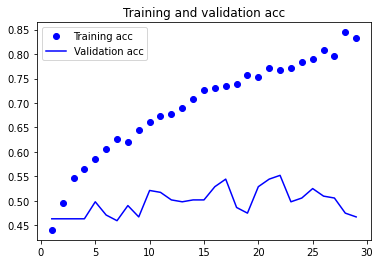

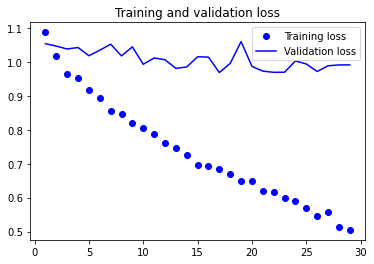

In [19]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [4]:
hist_df = pd.DataFrame(history_clf.history)

hist_csv = r'D:\dental\history\history_clf.csv'
with open(hist_csv, mode='w') as f:
    hist_df.to_csv(f)

NameError: name 'history_clf' is not defined

In [10]:
model = models.load_model('real4_dental_ResNet50V2_clf.h5')
model.load_weights('real4_dental_ResNet50V2_clf.h5')

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [12]:
model.layers[0].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 784, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 790, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 240, 392, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 242, 394, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [15]:
model.layers[0].layers[186].name

'conv5_block3_3_conv'

In [11]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == model.layers[0].layers[186].name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [12]:
len(model.trainable_weights)

8

In [13]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [14]:
callbacks_list_1 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 14,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real4_dental_ResNet50V2_1.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 10)
]

In [15]:
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [17]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 40),
    steps_per_epoch=50,
    epochs = 100,
    callbacks= callbacks_list_1,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
50/50 [==============================] - 106s 2s/step - loss: 0.4945 - acc: 0.8477 - val_loss: 0.9861 - val_acc: 0.5135
Epoch 2/100
50/50 [==============================] - 90s 2s/step - loss: 0.4949 - acc: 0.8422 - val_loss: 0.9622 - val_acc: 0.5135
Epoch 3/100
50/50 [==============================] - 89s 2s/step - loss: 0.4872 - acc: 0.8518 - val_loss: 0.9203 - val_acc: 0.5405
Epoch 4/100
50/50 [==============================] - 92s 2s/step - loss: 0.4603 - acc: 0.8658 - val_loss: 0.9036 - val_acc: 0.5676
Epoch 5/100
50/50 [==============================] - 88s 2s/step - loss: 0.4507 - acc: 0.8688 - val_loss: 0.8983 - val_acc: 0.5830
Epoch 6/100
50/50 [==============================] - 89s 2s/step - loss: 0.4441 - acc: 0.8762 - val_loss: 0.8943 - val_acc: 0.5560
Epoch 7/100
50/50 [==============================] - 90s 2s/step - loss: 0.4363 - acc: 0.8846 - val_loss: 0.8819 - val_acc: 0.5753
Epoch 8/100
50/50 [==============================] - 90s 2s/step - loss: 0.4291 - 

KeyboardInterrupt: 

In [18]:
history = model.history

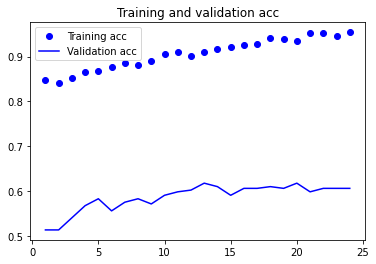

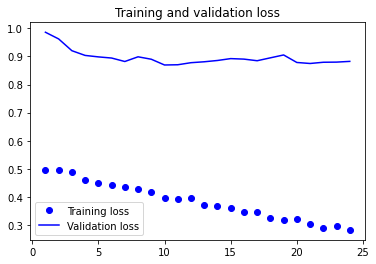

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model = models.load_model('real4_dental_ResNet50V2_1.h5')
model.load_weights('real4_dental_ResNet50V2_1.h5')

In [11]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block3_2_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [12]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [13]:
callbacks_list_2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 14,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real4_dental_ResNet50V2_2.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 5
     )
] 

In [14]:
model.compile(optimizer=optimizers.Adam(1e-6),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [15]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 30),
    steps_per_epoch=60,
    epochs = 100,
    callbacks= callbacks_list_2,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
60/60 [==============================] - 100s 2s/step - loss: 0.3746 - acc: 0.9092 - val_loss: 0.8784 - val_acc: 0.6139
Epoch 2/100
60/60 [==============================] - 82s 1s/step - loss: 0.3729 - acc: 0.9153 - val_loss: 0.8744 - val_acc: 0.6062
Epoch 3/100
60/60 [==============================] - 81s 1s/step - loss: 0.3634 - acc: 0.9243 - val_loss: 0.8753 - val_acc: 0.6062
Epoch 4/100
60/60 [==============================] - 82s 1s/step - loss: 0.3522 - acc: 0.9283 - val_loss: 0.8743 - val_acc: 0.6062
Epoch 5/100
60/60 [==============================] - 81s 1s/step - loss: 0.3714 - acc: 0.9130 - val_loss: 0.8766 - val_acc: 0.6062
Epoch 6/100
60/60 [==============================] - 81s 1s/step - loss: 0.3597 - acc: 0.9231 - val_loss: 0.8756 - val_acc: 0.6100
Epoch 7/100
60/60 [==============================] - 82s 1s/step - loss: 0.3461 - acc: 0.9272 - val_loss: 0.8758 - val_acc: 0.6100
Epoch 8/100
60/60 [==============================] - 83s 1s/step - loss: 0.3592 - 

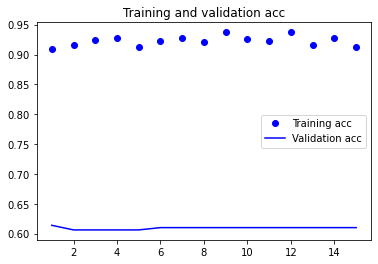

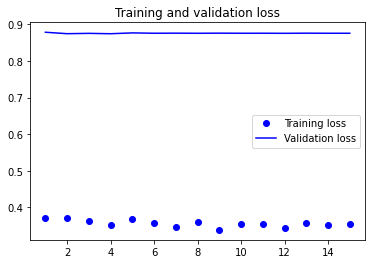

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model = models.load_model('real4_dental_ResNet50V2_2.h5')
model.load_weights('real4_dental_ResNet50V2_2.h5')

In [11]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [12]:
model.layers[0].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 784, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 790, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 240, 392, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 242, 394, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [13]:
callbacks_list_3 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 14,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real4_dental_ResNet50V2_3.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 5
     )
] 

In [14]:
model.compile(optimizer=optimizers.Adam(1e-7),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [15]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 30),
    steps_per_epoch=60,
    epochs = 100,
    callbacks= callbacks_list_3,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
60/60 [==============================] - 94s 2s/step - loss: 0.7126 - acc: 0.7216 - val_loss: 0.8928 - val_acc: 0.5714
Epoch 2/100
60/60 [==============================] - 79s 1s/step - loss: 0.7424 - acc: 0.7083 - val_loss: 0.8920 - val_acc: 0.5637
Epoch 3/100
60/60 [==============================] - 81s 1s/step - loss: 0.7149 - acc: 0.7305 - val_loss: 0.8913 - val_acc: 0.5637
Epoch 4/100
60/60 [==============================] - 80s 1s/step - loss: 0.7251 - acc: 0.7192 - val_loss: 0.8908 - val_acc: 0.5637
Epoch 5/100
60/60 [==============================] - 81s 1s/step - loss: 0.7357 - acc: 0.7126 - val_loss: 0.8908 - val_acc: 0.5637
Epoch 6/100
60/60 [==============================] - 80s 1s/step - loss: 0.7224 - acc: 0.7260 - val_loss: 0.8905 - val_acc: 0.5637
Epoch 7/100
60/60 [==============================] - 80s 1s/step - loss: 0.7343 - acc: 0.7136 - val_loss: 0.8905 - val_acc: 0.5637
Epoch 8/100


KeyboardInterrupt: 

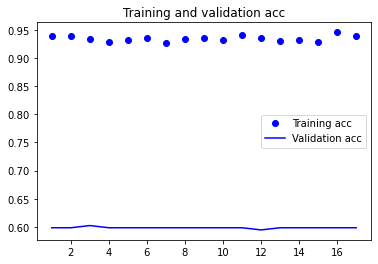

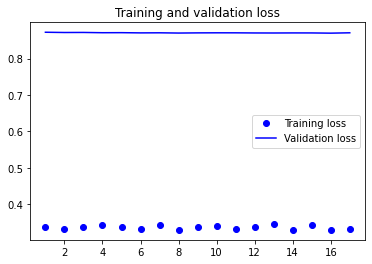

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## history 저장

In [49]:
hist_df = pd.DataFrame(history_3.history)

hist_3_csv = r'D:\dental\history\history_3.csv'
with open(hist_3_csv, mode='w') as f:
    hist_df.to_csv(f)